In [1]:
import cv2
import os
import numpy as np
import json
import pandas as pd
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity
from matplotlib import colors
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/siamese-registration')

from datasets import RandomTransformationDataset
from models import *
from utils import get_transformation_matrix

In [4]:
path = "/content/drive/MyDrive/data"
outputs_path = "/content/drive/MyDrive/outputs"

In [5]:
test_dataset = RandomTransformationDataset(
    transforms=transforms.Compose([
        transforms.ToTensor(),
    ]),
    path=os.path.join(path, "test.pkl"),
    path_prefix="/content/drive/MyDrive"
)

In [6]:
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=10, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

Running on cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# fc
models_info = [
    {
        "folder": "02_resnet18_MSE",
        "checkpoint": "model-9.pt",
        "type": "concatenation"
    },
    {
        "folder": "16_sub_MSE_fc",
        "checkpoint": "checkpoint-20.pt",
        "type": "subtraction"
    },
    {
        "folder": "07_resnet18_MSE_corr_2",
        "checkpoint": "checkpoint-24.pt",
        "type": "correlation"
    },
]
models = []
for m_i in models_info:
    model = initial_siamese_resnet18(1, 7, m_i["type"])
    if m_i["type"] == "concatenation":
        model.load_state_dict(torch.load(os.path.join(outputs_path, m_i["folder"], m_i["checkpoint"]), map_location=device))
    else:
        model.load_state_dict(torch.load(os.path.join(outputs_path, m_i["folder"], m_i["checkpoint"]), map_location=device)['model_state_dict'])
    model.cuda()
    model.eval()
    models.append(model)

In [7]:
# reg
models_info = [
    {
        "folder": "17_cat_MSE_reg",
        "checkpoint": "checkpoint-20.pt",
        "channels": [1024, 128, 64],
        "type": "concatenation"
    },
    {
        "folder": "15_sub_MSE_reg",
        "checkpoint": "checkpoint-19.pt",
        "channels": [512, 128, 64],
        "type": "subtraction"
    },
    {
        "folder": "11_resnet18_wMSE_corr_reg_4", # 11_resnet18_wMSE_corr_reg_4, 08_resnet18_MSE_corr_reg
        "checkpoint": "checkpoint-17.pt", # 17, 20
        "channels": [384, 128, 64],
        "type": "correlation"
    },
]
models = []
for m_i in models_info:
    model = siamese_resnet18(1, 7, m_i["type"], m_i["channels"])
    model.load_state_dict(torch.load(os.path.join(outputs_path, m_i["folder"], m_i["checkpoint"]), map_location=device)['model_state_dict'])
    model.cuda()
    model.eval()
    models.append(model)

In [ ]:
#del models

In [8]:
loader = iter(test_loader)

In [9]:
def warp_from_params_and_eval(img0, img1, params):
    tx, ty, sx, sy, shx, shy, q = params
    rows, cols = img0.shape
    center = (cols//2, rows//2)
    matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)
    matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
    inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
    img1_warped = cv2.warpAffine(img1, inverse_matrix, (cols, rows))
    mask = (img1_warped != 0.0)
    mse = mean_squared_error(img0[mask], img1_warped[mask])
    ssim = structural_similarity(img0[mask], img1_warped[mask])
    return img1_warped, mse, ssim 

def warp_and_eval(img0, img1, method="sift"):
    rows, cols = img0.shape
    if method == "sift":
        detector = cv2.xfeatures2d.SIFT_create()
    elif method == "orb":
        detector = cv2.ORB_create(nfeatures=10000)
    else:
        raise NotImplemented()
    
    kp1, d1 = detector.detectAndCompute(img1, None)
    kp2, d2 = detector.detectAndCompute(img0, None)

    if (d1 is None) or (d2 is None):
        return img1, np.nan, np.nan

    matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)
    matches = matcher.match(d1, d2)
    matches = sorted(matches, key = lambda x:x.distance)
    matches.sort(key = lambda x: x.distance)
    matches = matches[:int(len(matches)*0.9)]

    no_of_matches = len(matches)
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
    for i in range(len(matches)):
      p1[i, :] = kp1[matches[i].queryIdx].pt
      p2[i, :] = kp2[matches[i].trainIdx].pt
    try:
        #homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
        homography, mask = cv2.estimateAffinePartial2D(p1, p2)
        #print(f"{homography=}")
    except:
        return img1, np.nan, np.nan
    img1_warped = cv2.warpAffine(img1, homography, (cols, rows))
    #img = cv2.drawMatches(img0, kp1, img0, kp2, matches[:100], img1, flags=2)
    #plt.imshow(img),plt.show()
    mask = (img1_warped != 0.0)
    mse = mean_squared_error(img0[mask], img1_warped[mask])
    ssim = structural_similarity(img0[mask], img1_warped[mask])
    return img1_warped, mse, ssim

In [11]:
param_list = []
outputs1 = []
outputs2 = []
outputs3 = []
mse_gt = []
ssim_gt = []
mse0 = []
mse1 = []
mse2 = []
mse3 = []
ssim0 = []
ssim1 = []
ssim2 = []
ssim3 = []
mse_orb = []
ssim_orb = []
mse_sift = []
ssim_sift = []
i = 0
with tqdm(test_loader) as validation_progress:
    for img0, img1, params in validation_progress:
        i += 1
        
        img0, img1, params = img0.to(device=device), img1.to(device=device), params.to(device=device)
        param_list.append(params.detach().cpu().numpy().reshape(-1).tolist())
        #out = models[0](img0, img1)
        #outputs1.append(out.detach().cpu().numpy().reshape(-1).tolist())
        #out = models[1](img0, img1)
        #outputs2.append(out.detach().cpu().numpy().reshape(-1).tolist())
        #out = models[2](img0, img1)
        #outputs3.append(out.detach().cpu().numpy().reshape(-1).tolist())

        frame0 = img0.detach().cpu().numpy()[0, 0, :, :]
        frame0 = (frame0 * 255).astype('uint8')
        frame1 = img1.detach().cpu().numpy()[0, 0, :, :]
        frame1 = (frame1 * 255).astype('uint8')

        #mse0.append(mean_squared_error(frame0, frame1))
        #ssim0.append(structural_similarity(frame0, frame1))
        #_, gt_mse, gt_ssim = warp_from_params_and_eval(frame0, frame1, param_list[-1])
        #mse_gt.append(gt_mse)
        #ssim_gt.append(gt_ssim)
        #_, net_mse1, net_ssim1 = warp_from_params_and_eval(frame0, frame1, outputs1[-1])
        #mse1.append(net_mse1)
        #ssim1.append(net_ssim1)
        #_, net_mse2, net_ssim2 = warp_from_params_and_eval(frame0, frame1, outputs2[-1])
        #mse2.append(net_mse2)
        #ssim2.append(net_ssim2)
        #_, net_mse3, net_ssim3 = warp_from_params_and_eval(frame0, frame1, outputs3[-1])
        #mse3.append(net_mse3)
        #ssim3.append(net_ssim3)

        if True:
            try:
                _, orb_mse, orb_ssim = warp_and_eval(frame0, frame1, method="orb")
                mse_orb.append(orb_mse)
                ssim_orb.append(orb_ssim)
            except:
                mse_orb.append(np.nan)
                ssim_orb.append(np.nan)
            #try:
            #    _, sift_mse, sift_ssim = warp_and_eval(frame0, frame1, method="sift")
            #    mse_sift.append(sift_mse)
            #    ssim_sift.append(sift_ssim)
            #except:
            #    mse_sift.append(np.nan)
            #    ssim_sift.append(np.nan)
        #if i == 1:
        #    break
        
        

100%|██████████| 8000/8000 [11:28<00:00, 11.62it/s]


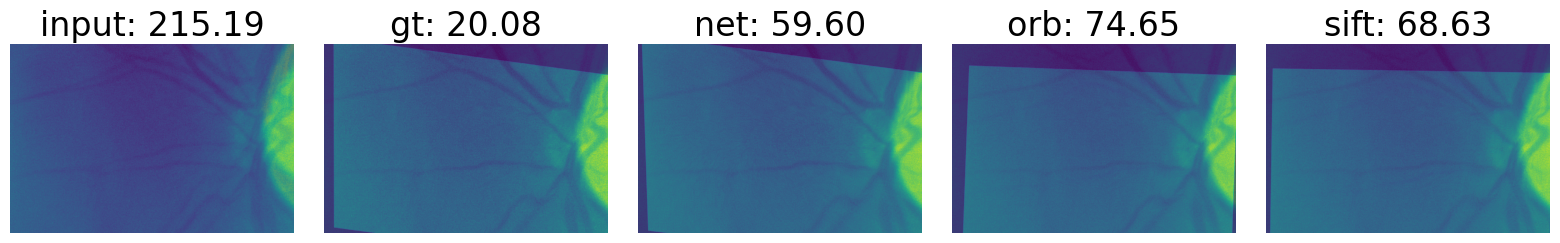

In [24]:
input_mse = mean_squared_error(frame0, frame1)
gt_im, gt_mse, gt_ssim = warp_from_params_and_eval(frame0, frame1, param_list[-1])
net_im, net_mse, net_ssim = warp_from_params_and_eval(frame0, frame1, outputs3[-1])
orb_im, orb_mse, orb_ssim = warp_and_eval(frame0, frame1, method="orb")
sift_im, sift_mse, sift_ssim = warp_and_eval(frame0, frame1, method="sift")

plt.figure(figsize = (16,9))
plt.rc('font', size=20)
plt.subplot(151)
plt.axis('off')
plt.title(f'input: {input_mse:.2f}')
plt.imshow(frame0)
plt.imshow(frame1, alpha=0.4)

plt.subplot(152)
plt.axis('off')
plt.title(f'gt: {gt_mse:.2f}')
plt.imshow(frame0)
plt.imshow(gt_im, alpha=0.4)

plt.subplot(153)
plt.axis('off')
plt.title(f'net: {net_mse:.2f}')
plt.imshow(frame0)
plt.imshow(net_im, alpha=0.4)

plt.subplot(154)
plt.axis('off')
plt.title(f'orb: {orb_mse:.2f}')
plt.imshow(frame0)
plt.imshow(orb_im, alpha=0.4)

plt.subplot(155)
plt.axis('off')
plt.title(f'sift: {sift_mse:.2f}')
plt.imshow(frame0)
plt.imshow(sift_im, alpha=0.4)


plt.tight_layout()
plt.show()

In [ ]:
base = mean_squared_error(frame0, frame1)
gt = warp_and_mse(frame0, frame1, param_list[-1])[0]
net = warp_and_mse(frame0, frame1, outputs3[-1])[0]
orb = warp_orb_and_mse(frame0, frame1)[0]
sift = warp_sift_and_mse(frame0, frame1)[0]


print(f"{base=}\n  {gt=}\n {net=}\n {orb=}\n{sift=}\n")

base=280.4102
  gt=25.066307304316425
 net=406.99401137404186
 orb=776.3610546980774
sift=576.3077203658787



In [14]:
#d = {'mse_gt': mse_gt, 'ssim_gt': ssim_gt, 'mse0': mse0, 'mse1': mse1, 'mse2': mse2, 'mse3': mse3, 'ssim0': ssim0, 'ssim1': ssim1, 'ssim2': ssim2, 'ssim3': ssim3, 'mse_orb': mse_orb, 'ssim_orb': ssim_orb, 'mse_sift': mse_sift, 'ssim_sift': ssim_sift }
#d = {'mse_gt': mse_gt, 'ssim_gt': ssim_gt, 'mse0': mse0, 'mse1': mse1, 'mse2': mse2, 'mse3': mse3, 'ssim0': ssim0, 'ssim1': ssim1, 'ssim2': ssim2, 'ssim3': ssim3 }
d = {'mse_orb': mse_orb, 'ssim_orb': ssim_orb, 'mse_sift': mse_sift, 'ssim_sift': ssim_sift}

In [15]:
df = pd.DataFrame(d)
df

,mse_orb,ssim_orb
0,NaN,NaN
1,251.795553,0.693967
2,NaN,NaN
3,74.289778,0.700215
4,NaN,NaN
...,...,...
7995,NaN,NaN
7996,39.687303,0.686569
7997,57.811989,0.739413
7998,NaN,NaN


In [20]:
#df.to_csv(os.path.join("/content/drive/MyDrive/outputs", "outputs-err-comp2.csv"))

In [ ]:
#df = pd.read_csv("/content/drive/MyDrive/outputs/outputs-err-comp2.csv")
#df = df.rename(columns={"err1": "concatenation", "err2": "subtraction", "err3": "correlation"})
#df['orb'] = df.orb.replace(1.0, np.nan)
#df['sift'] = df.sift.replace(1.0, np.nan)

In [16]:
df.describe()

,mse_orb,ssim_orb
count,5324.000000,5324.000000
mean,175.238445,0.673447
std,670.931911,0.106096
min,8.547673,0.132478
25%,61.941012,0.596392
50%,90.346846,0.687773
75%,137.733230,0.752852
max,22822.598266,0.945081


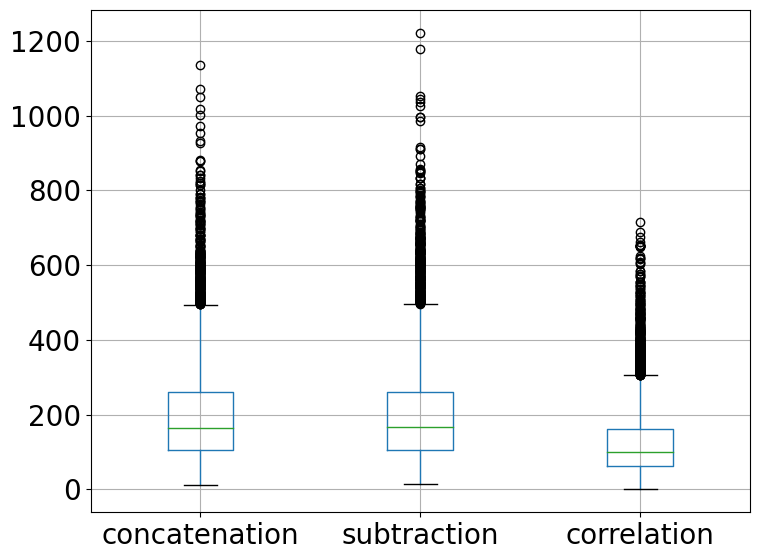

In [ ]:
plt.figure(figsize=(8,6))
plt.rc('font', size=20)
boxplot = df.boxplot(column = ['concatenation', 'subtraction', 'correlation'])
plt.tight_layout()
#plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "err-fc.png"))